In [41]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import scipy
import plotly.express as px
from scipy import stats
from tqdm.auto import tqdm
from scipy.stats import norm
from scipy.stats import levene

In [42]:
# Считываем данные
df = pd.read_csv('/home/jupyter-o.kvashnevskii-3/Pride Games Studio/PGS_Analitics_Test.csv')

In [43]:
df.head()

,Level,ID,Version,Country
0,1,1160211,1,United States
1,2,1160211,1,United States
2,3,1160211,1,United States
3,4,1160211,1,United States
4,5,1160211,1,United States


In [44]:
df.shape

(62265, 4)

In [45]:
df.dtypes

Level       int64
ID          int64
Version     int64
Country    object
dtype: object

In [46]:
max_lvl = df.groupby('ID').Level.max()

In [47]:
df = df.merge(max_lvl, on = 'ID')

In [48]:
df = df.rename(columns = {'Level_x' : 'Level', 'Level_y' : 'Max_level'})

In [49]:
# Количество уникальных пользователей в каждой группe
df.groupby('Version', as_index = False) \
  .agg({'ID' : 'nunique'}) \
  .rename(columns={'ID' : 'Users'})

,Version,Users
0,1,4812
1,2,7234


In [50]:
df.groupby('Version', as_index=False).agg({'ID' : 'count'})

,Version,ID
0,1,24542
1,2,37723


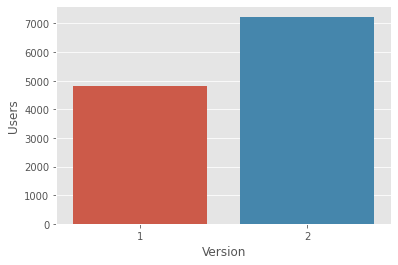

In [51]:
# Количество уникальных пользователей в каждой группe
sns.barplot(x= 'Version', y = 'Users',data = df.groupby('Version', as_index = False) \
                                            .agg({'ID' : 'nunique'}) \
                                            .rename(columns={'ID' : 'Users'}))

Есть пользователи с неизвестной страной. Заменим NaN на Unknown.

In [52]:
df.isna().sum()

Level           0
ID              0
Version         0
Country      1468
Max_level       0
dtype: int64

In [53]:
df['Country'] = df['Country'].fillna('Unknown')

In [54]:
df.isna().sum()

Level        0
ID           0
Version      0
Country      0
Max_level    0
dtype: int64

In [55]:
# Топ-10 стран по количеству пользователей в тесте
df.groupby('Country', as_index= False) \
    .agg({'ID' : 'nunique'}) \
    .rename(columns = {'ID' : 'Users'}) \
    .sort_values('Users', ascending=False) \
    .head(10)

,Country,Users
101,Russian Federation,1787
126,United States,825
52,"Iran, Islamic Republic of",809
50,India,742
123,Ukraine,705
16,Brazil,683
51,Indonesia,385
127,Unknown,313
96,Poland,292
95,Philippines,260


Создадим категории прогресса и посмотрим на распределение по главам, уровням в каждой группе.

In [56]:
# Создание категорий прогесса
df['Progress'] = pd.cut(df['Level'], [1, 3, 10, 24, 44, 51], 
                 labels = ['Обучение', '1 глава', '2 глава', '3 глава', '4 глава'],right=False)

In [57]:
df_gl_control = df.query('Version == 1') \
    .groupby('Progress', as_index=False) \
    .agg({'ID' : 'nunique'}) \
    .rename(columns = {'ID' : 'Users'})

In [58]:
df_gl_test = df.query('Version == 2') \
    .groupby('Progress', as_index=False) \
    .agg({'ID' : 'nunique'}) \
    .rename(columns = {'ID' : 'Users'})

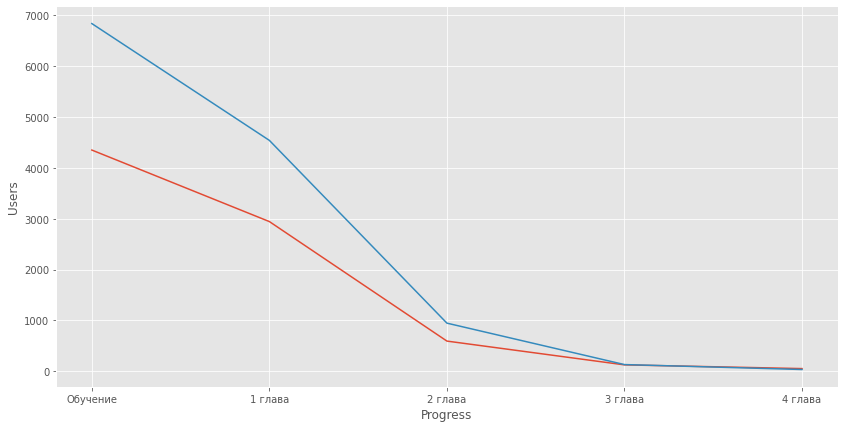

In [59]:
# Визуализация по главам
plt.figure(figsize=(14,7))
sns.lineplot(x = 'Progress', y = 'Users', data = df_gl_control)
sns.lineplot(x = 'Progress', y = 'Users', data = df_gl_test)

In [60]:
df_lvl_control = df.query('Version == 1') \
    .groupby('Level', as_index=False) \
    .agg({'ID' : 'count'}) \
    .rename(columns = {'ID' : 'Users'})

In [61]:
df_lvl_test = df.query('Version == 2') \
    .groupby('Level', as_index=False) \
    .agg({'ID' : 'count'}) \
    .rename(columns = {'ID' : 'Users'})

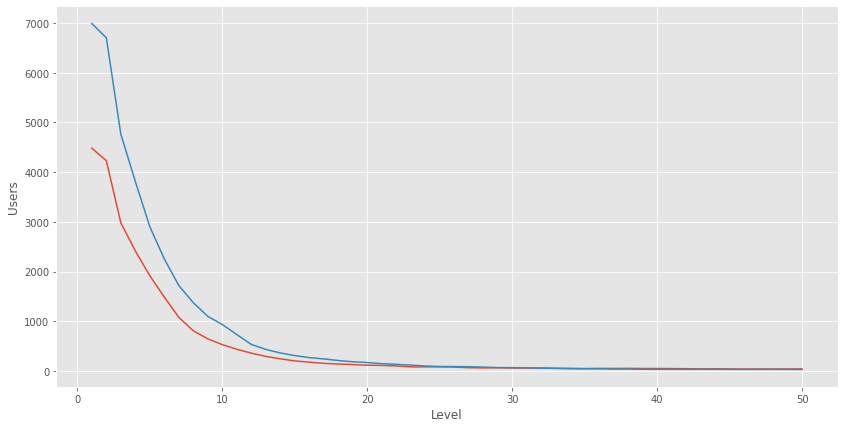

In [62]:
# Визуализация по уровням
plt.figure(figsize=(14,7))
sns.lineplot(x = 'Level', y = 'Users', data = df_lvl_control)
sns.lineplot(x = 'Level', y = 'Users', data = df_lvl_test)

Проверим выполнение условий на нормальность распределения,посчитаем стандартное отклонение 
и среднее значение пройденных уровней пользователем в каждой группе.

In [63]:
stats.shapiro(df.query('Version == 1').Max_level.sample(1000, random_state=17))

(0.747336208820343, 1.791775639974255e-36)

In [64]:
stats.shapiro(df.query('Version == 2').Max_level.sample(1000, random_state=17))

(0.7577522993087769, 6.654106608499226e-36)

В обеих группах значение p-value < 0.05. Это значит, что распределения отличаются от нормального.

In [65]:
# Стандартное отклонение в контрольной группе
round(df.query('Version == 1').Max_level.std(), 2)

12.91

In [66]:
# Стандартное отклонение в тестовой группе
round(df.query('Version == 2').Max_level.std(), 2)

10.15

In [67]:
stat, p = levene(df.query('Version == 1').Max_level, df.query('Version == 2').Max_level)

In [68]:
p

4.724581787563417e-93

Проверив требование гомогенности дисперсий через критерий Левена приходим к выводу, что применить t-критерий Стьюдента не получится, т.к. значение p-value < 0.05. 

In [72]:
# Среднее количество пройденных уровней в контрольной группе
mean_control = df.query('Version == 1').Max_level.mean()

In [73]:
# Среднее количество пройденных уровней в тестовой группе
mean_test = df.query('Version == 2').Max_level.mean()

In [74]:
round((mean_test / mean_control - 1) * 100, 2)

-13.99

Среднее количество пройденных уровней в тестовой группе ниже на 13.99%.

С помощью бутстрапа проверим статистическую значимость разницы среднего значчения пройденных уровней.

In [75]:
def bootstrap(
    data_column_1, # числовые значения первой выборки
    data_column_2, # числовые значения второй выборки
    boot_it = 1000, # количество бутстрэп-подвыборок
    statistic = np.mean, # интересующая нас статистика
    bootstrap_conf_level = 0.95 # уровень значимости
):
    boot_len = max([len(data_column_1), len(data_column_2)])
    boot_data = []
    for i in tqdm(range(boot_it)): # извлекаем подвыборки
        samples_1 = data_column_1.sample(
            boot_len, 
            replace = True # параметр возвращения
        ).values
        
        samples_2 = data_column_2.sample(
            boot_len, 
            replace = True
        ).values
        
        boot_data.append(statistic(samples_1-samples_2)) # mean() - применяем статистику
        
    pd_boot_data = pd.DataFrame(boot_data)
        
    left_quant = (1 - bootstrap_conf_level)/2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    quants = pd_boot_data.quantile([left_quant, right_quant])
        
    p_1 = norm.cdf(
        x = 0, 
        loc = np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_2 = norm.cdf(
        x = 0, 
        loc = -np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2
        
    # Визуализация
    _, _, bars = plt.hist(pd_boot_data[0], bins = 50)
    for bar in bars:
        if abs(bar.get_x()) <= quants.iloc[0][0] or abs(bar.get_x()) >= quants.iloc[1][0]:
            bar.set_facecolor('red')
        else: 
            bar.set_facecolor('grey')
            bar.set_edgecolor('black')
    
    plt.style.use('ggplot')
    plt.vlines(quants,ymin=0,ymax=50,linestyle='--')
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title("Histogram of boot_data")
    plt.show()
       
    return {"boot_data": boot_data, 
            "quants": quants, 
            "p_value": p_value}

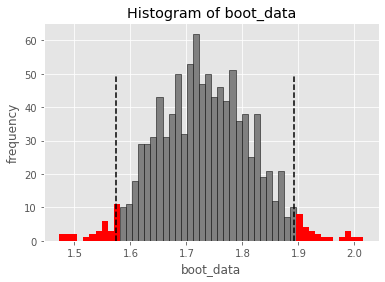

In [76]:
control = df.query('Version == 1').Max_level
test = df.query('Version == 2').Max_level
mean = bootstrap(control, test)

In [77]:
mean['quants']

,0
0.025,1.573699
0.975,1.892679


In [78]:
mean['p_value']

3.996234532294883e-93

Отвергаем нулевую гипотезу т.к. доверительный интервал не пересекает 0;
Это значит, что разница среднего количества пройденных уровней статистическа значима.

Вывод:
1. Фича, которая была добавлена и протестирована в одной из групп статистически значимо уменьшила среднее количество проходимых уровней пользователями примерно на 14%. Рекомендую не раскатывать её на всех пользователей и вернуть игру к старой версии.
2. Исправить баг в записи данных при котором в колонку "Country" ничего не попадает.
3. Исправить систему сплитования для А/В тестирования. Был найден пользователь, который попал в обе группы (ID == 1121327).